# <center>PROJECT-3</center>
─────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     
    Анализ воронки в Python
    проект в рамках курса SkillFactory, DARP-1014
    Медведевой Н.А, medvedeva.n.box@yandex.ru

- **ОБЪЕКТ :** Мобильная игра Quiz Freeze
- **ЦЕЛЬ :** Исследовать поведение пользователей в обновлённом приложении. **``Проверить гипотезы:``**
    
      Гипотеза 1. Должна быть разница в поведении групп, которые проходят и не проходят обучение. Влияет ли обучение на скорость прохождения других этапов игры?
      Гипотеза 2. Повторное прохождение обучения положительно влияет на оплату?
      Гипотеза 3. Если пользователь сначала выбирает сложность обучения, будет ли он потом проходить обучение?
    


**Примечание!** Анализ проводится на основе данных пользователей, зарегистрированных в 2018 году ``01.01.2018 - 31.12.2018`` 

In [21]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px

%matplotlib inline


events_df = pd.read_csv('data/events.csv', sep=',') 
purchase_df = pd.read_csv('data/purchase.csv', sep=',')

##  ``СВОДНАЯ ТАБЛИЦА событий и оплат total_df  ( 68559 rows )`` 
    1. events (66959 rows) - выборка всех событий для пользователей зарегестрированныx в 2018г из таблицы events_df
    2. purchase (1600 rows) - выборка всех событий для пользователей зарегестрированныx в 2018г из таблицы purchase_df 
    3. total_df (68559 rows) - cводная таблица событий и оплат для пользователей зарегестрированных в 2018г

In [22]:
# 1. ФОРМИРОВАНИЕ ВЫБОРКИ events (66 959 rows) 
time = pd.to_datetime(events_df['start_time'], dayfirst=True, errors ='coerce') # start_time в формат datetime
events_df['start_time'] = time
users_reg2018 = events_df[(events_df['event_type']=='registration')             # id пользователей зарег-x в 2018г
                          &(events_df['start_time']>='2018-01-01')
                          &(events_df['start_time']<'2019-01-01')]['user_id']
users_2018 = pd.DataFrame({'user_id': users_reg2018})            # df - 19926 rows 
events = events_df.merge(users_2018, how='inner', on='user_id')  # выборка events (66959 х 7)
events = events.rename(columns={'id': 'event_id'})               # переименование признака id             



# 2. ФОРМИРОВАНИЕ ВЫБОРКИ purchase (1 600 rows) 
date = pd.to_datetime(purchase_df['event_datetime'], dayfirst=True) # start_time в формат datetime:
purchase_df['event_datetime'] = date     
purchase = purchase_df.merge(users_2018, how='inner', on='user_id') # выборка purchase (1600 rows x 5 columns) 
purchase['event_type'] = 'purchase'                                 # cоздание маркера покупки
purchase = purchase.rename(columns={'id':'purchase_id','event_datetime':'start_time'}) # переименование признака id 



# 3. СВОДНАЯ ТАБЛИЦА событий и оплат для пользователей зарегестрированных в 2018г: total_df (1 600 rows)
#    объединение таблиц событий и оплат методом конкатанации
#    сброс индексов. Сортировкка всех событий по возрастанию start_time  
total_df = pd.concat([events,purchase],sort=False)
total_df = total_df.reset_index(drop=True).sort_values('start_time')
total = total_df.copy()
display('total_df - сводная таблица',total_df.head())


'total_df - сводная таблица'

,event_id,event_type,selected_level,start_time,tutorial_id,user_id,purchase_id,amount
0,80308.0,registration,NaN,2018-01-01 03:48:40,NaN,27832,NaN,NaN
1,80309.0,registration,NaN,2018-01-01 04:07:25,NaN,27833,NaN,NaN
4,80310.0,registration,NaN,2018-01-01 08:35:10,NaN,27834,NaN,NaN
7,80311.0,registration,NaN,2018-01-01 11:54:47,NaN,27835,NaN,NaN
12,80312.0,registration,NaN,2018-01-01 13:28:07,NaN,27836,NaN,NaN


## ``ПОДГОТОВИТЕЛЬНЫЙ ЭТАП``
    1. times_df - сводная таблица времени первых событий для каждого пользователя (19926 rows х 6 cols)
    2. count_events_df - сводная таблица количества событий для каждого пользователя (19926 rows x 6 cols)

In [23]:
#   маркеры уровня сложности для user_ids
lvls_group = total_df.pivot_table(index='user_id', values ='selected_level', aggfunc = 'sum') # display(lvls_group)

#   Дополнительные столбцы в total_df / 68559 rows
total_df['tutorial_start'] = total_df.apply(lambda x: x.iloc[3] if x.iloc[1] == 'tutorial_start' else None, axis=1)
total_df['tutorial_finish'] = total_df.apply(lambda x: x.iloc[3] if x.iloc[1] == 'tutorial_finish' else None, axis=1)
total_df['level_choice'] = total_df.apply(lambda x: x.iloc[3] if x.iloc[1] == 'level_choice' else None, axis=1)
total_df['pack_choice'] = total_df.apply(lambda x: x.iloc[3] if x.iloc[1] == 'pack_choice' else None, axis=1)
total_df['purchase'] = total_df.apply(lambda x: x.iloc[3] if x.iloc[7] > 0 else None, axis=1)


# 1. Сводная таблица времени первых событий для каждого пользователя / 19926 rows х 6 cols
cols = ['tutorial_start','tutorial_finish','level_choice','pack_choice','purchase'] # список для фильтра
times_df = total_df.groupby(['user_id'])[cols].min().reset_index()
display(times_df.tail(),'Сводная таблица времени первых событий для каждого пользователя')


# 2. Сводная таблица количества событий для каждого пользователя / 19926 rows х 6 cols
counts_df = total_df.groupby(['user_id'])[cols].count().reset_index()
display(counts_df.tail(),'Сводная таблица количества событий для каждого пользователя')


,user_id,tutorial_start,tutorial_finish,level_choice,pack_choice,purchase
19921,47753,2018-12-31 20:54:56,2018-12-31 20:57:07,2018-12-31 22:36:19,2018-12-31 22:38:05,NaT
19922,47754,NaT,NaT,NaT,NaT,NaT
19923,47755,2019-01-01 00:08:14,2019-01-01 00:09:30,2019-01-01 05:04:52,NaT,NaT
19924,47756,2019-01-01 03:26:18,2019-01-01 03:29:25,2019-01-01 05:42:11,2019-01-01 05:50:36,NaT
19925,47757,NaT,NaT,NaT,NaT,NaT


'Сводная таблица времени первых событий для каждого пользователя'

,user_id,tutorial_start,tutorial_finish,level_choice,pack_choice,purchase
19921,47753,1,1,1,1,0
19922,47754,0,0,0,0,0
19923,47755,1,1,1,0,0
19924,47756,1,1,1,1,0
19925,47757,0,0,0,0,0


'Сводная таблица количества событий для каждого пользователя'

─────────────────────────────────────────────────────────────────────────────────────────────────────────────────
## ``ГИПОТЕЗА 1 :  Должна быть разница в поведении групп, которые проходят и не проходят обучение. Влияет ли обучение на скорость прохождения других этапов игры``
Определите, насколько обучение сокращает время прохождения этапов игры

    1. Группы пользователей s1: 10250 users, s2: 98 users, s3: 1608 users / Визуализация групп
    2. Временные промежутки / Timedelta для событий выбора сложности, выбора пакетов и покупки
    3. Тайминги всех событий для групп s1, s2, s3
    4. Сравнение средних таймингов
    5. Визуализации
    6. Разница показателей
─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Время прохождения этапа [выбор сложности - выбор пакетов], 5176 пользователей
           среднее время:                75%:
Группа s1:  0 days 00:05:18.146058732,  0 days 00:07:11
Группа s2:  0 days 00:05:23.824324324,  0 days 00:07:11.250000
Группа s3:  0 days 00:05:05.295687885,  0 days 00:06:37

Время прохождения этапа [выбор пакетов - оплата], 1447 пользователей
           среднее время:                 75%:                     мин. время:        макс. врем:
Группа s1:  3 days 17:17:59.641326883,  5 days 08:53:44.500000,  0 days 00:44:50,  10 days 18:33:59
Группа s2:  4 days 04:49:33.590909090,  5 days 23:34:55.750000,  0 days 09:35:48,  7 days 11:56:49
Группа s3:  3 days 21:14:46.908396946,  5 days 13:41:45,         0 days 05:29:38,  8 days 15:27:43

Квантиль 75%
группа s1 быстрее группы s2 на 8ч (6%)
группа s1 быстрее группы s3 на 12ч (8%)

Среднее
группа s1 быстрее группы s2 на 12ч (11%)
группа s1 быстрее группы s3 на 4ч (4%)


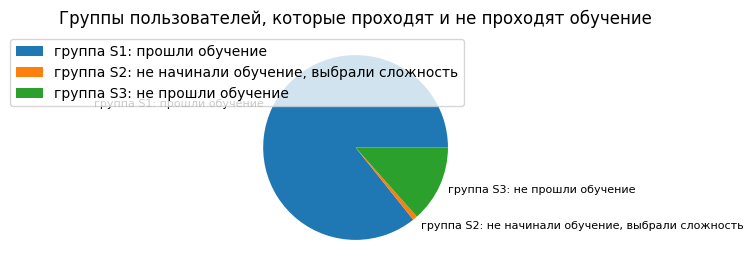

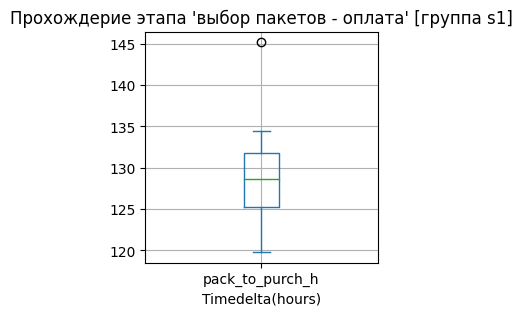

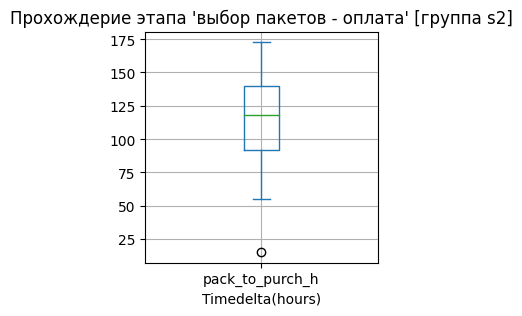

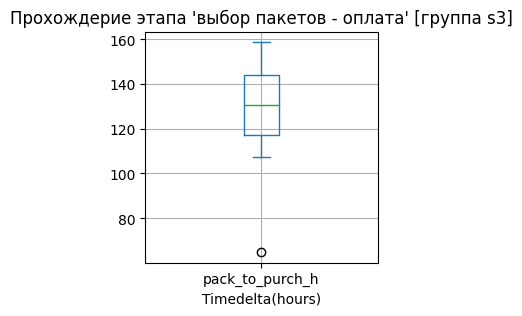

In [24]:
# ГИПОТЕЗА 1
# Cравним время прохождения различных этапов для пользователей. Если показатель отличается, выясним, насколько. 

# 1. Группы пользователей, которые проходят и не проходят обучение 
#    10250 пользователей прошли обучение хотя бы раз (группа s1 - успешные обучения)
#    98 пользователей не начинали обучение, но выбрали сложность (группа s2)
#    1608 пользователей начинали обучение, но не завершившие его ни разу (группа s3 - не успешные обучения)
s1_set = set(counts_df[counts_df['tutorial_finish'] >0]['user_id'])
s2_set = set(counts_df[(counts_df['level_choice'] >0) & (counts_df['tutorial_start'] ==0)]['user_id'])
s3_set = set(counts_df[(counts_df['tutorial_start'] >0) & (counts_df['tutorial_finish'] ==0)]['user_id'])
#    все длины множеств в df
s1_len = pd.Series(data=len(s1_set),index=['группа S1: прошли обучение']) 
s2_len = pd.Series(data=len(s2_set),index=['группа S2: не начинали обучение, выбрали сложность'])
s3_len = pd.Series(data=len(s3_set),index=['группа S3: не прошли обучение'])
#    Визуализация групп
set_df = pd.concat([s1_len, s2_len, s3_len], axis=0)  # display(set_df)
set_df.plot(
    kind='pie',
    figsize=(3,3),
    legend=True,
    title='Группы пользователей, которые проходят и не проходят обучение',
    fontsize = 8,
    rot=0
    );



# 2. Временные промежутки / Timedelta для событий level_choice - pack_choice - purchase
times_df['lvl_to_pack'] = (times_df['pack_choice'] - times_df['level_choice'])
times_df['pack_to_purch'] = (times_df['purchase'] - times_df['pack_choice'])

#   Конвер. длительности в часы
def to_hours(d):
    x = str(d)
    if x[1] == ' ':
        hours = int(x[0])*24 + int(x[7:9]) + int(x[10:12])/60
        return round(hours,2)
    elif x[2] == ' ':
        hours1 = int(x[0:2])*24 + int(x[8:10]) + int(x[11:13])/60
        return round(hours1,2)
    else:
        'out of range'
        
#   Доп.столбцы: начало обучения и выбор уровня в формате %Y-%M / Timedelta 'pack_to_purch' в часах
times_df['month_start'] = times_df['tutorial_start'].apply(lambda x: str(x))
times_df['month_start'] = times_df['month_start'].apply(lambda x: x[:7])
times_df['month_lvl'] = times_df['level_choice'].apply(lambda x: str(x))
times_df['month_lvl'] = times_df['month_lvl'].apply(lambda x: x[:7])
times_df['pack_to_purch_h'] = times_df['pack_to_purch'].apply(to_hours)


# 3. Тайминги всех событий для групп s1, s2, s3
times_s1 = times_df[times_df['user_id'].isin(s1_set)]   # 10250 rows 
times_s2 = times_df[times_df['user_id'].isin(s2_set)]   #    98 rows 
times_s3 = times_df[times_df['user_id'].isin(s3_set)]   #  1608 rows


# 4. Сравнение средних таймингов у групп s1, s2, s3
print(f'Время прохождения этапа [выбор сложности - выбор пакетов], {times_s1.lvl_to_pack.count()} пользователей')
print('           среднее время:                75%:')
print(f'Группа s1:  {times_s1.lvl_to_pack.mean()},  {times_s1.lvl_to_pack.quantile(0.75)}')
print(f'Группа s2:  {times_s2.lvl_to_pack.mean()},  {times_s2.lvl_to_pack.quantile(0.75)}')
print(f'Группа s3:  {times_s3.lvl_to_pack.mean()},  {times_s3.lvl_to_pack.quantile(0.75)}')   
print(f'\nВремя прохождения этапа [выбор пакетов - оплата], {times_s1.pack_to_purch.count()} пользователей')
print('           среднее время:                 75%:                     мин. время:        макс. врем:')
print(f'Группа s1:  {times_s1.pack_to_purch.mean()},  {times_s1.pack_to_purch.quantile(0.75)},  {times_s1.pack_to_purch.min()},  {times_s1.pack_to_purch.max()}')
print(f'Группа s2:  {times_s2.pack_to_purch.mean()},  {times_s2.pack_to_purch.quantile(0.75)},  {times_s2.pack_to_purch.min()},  {times_s2.pack_to_purch.max()}')
print(f'Группа s3:  {times_s3.pack_to_purch.mean()},  {times_s3.pack_to_purch.quantile(0.75)},         {times_s3.pack_to_purch.min()},  {times_s3.pack_to_purch.max()}')   



# 5. Визуализации 
#    как 75% группы s1 проходят этап pack_to_purch
s1_group = times_s1.groupby('month_start')['pack_to_purch_h'].quantile(0.75).dropna().reset_index() # display(s1_group.describe())
s1_group.plot(
    kind='box',
    grid=True,
    figsize=(3,3),
    legend=True,
    xlabel = 'Timedelta(hours)',
    title="Прохождерие этапа 'выбор пакетов - оплата' [группа s1]"
    ); 

#   как 75% группы s2 проходят этап pack_to_purch
s2_group = times_s2.groupby('month_lvl')['pack_to_purch_h'].quantile(0.75).dropna().reset_index() # display(group_s2.describe())
s2_group.plot(
    kind='box',
    grid=True,
    figsize=(3,3),
    legend=True,
    xlabel = 'Timedelta(hours)',
    title="Прохождерие этапа 'выбор пакетов - оплата' [группа s2]"
    ); 

#   как 75% группы s3 проходят этап pack_to_purch
s3_group = times_s3.groupby('month_start')['pack_to_purch_h'].quantile(0.75).dropna().reset_index()  # display(s3_group.describe())
s3_group.plot(
    kind='box',
    grid=True,
    figsize=(3,3),
    legend=True,
    xlabel = 'Timedelta(hours)',
    title="Прохождерие этапа 'выбор пакетов - оплата' [группа s3]"
    ); 

# 6. Разница показателей. 
perc75_s1 = s1_group.pack_to_purch_h.quantile(0.75) # 132ч ~ 5.5дн.
perc75_s2 = s2_group.pack_to_purch_h.quantile(0.75) # 140ч ~ 5.8дн.
perc75_s3 = s3_group.pack_to_purch_h.quantile(0.75) # 144ч ~ 6дн.

mean_s1 = times_s1.pack_to_purch_h.mean() # 89ч ~ 3.7дн.
mean_s2 = times_s2.pack_to_purch_h.mean() # 101ч ~ 4.2дн.
mean_s3 = times_s3.pack_to_purch_h.mean() # 93ч ~ 3.9дн.

#   Сравниваем процентили 75%, те большую часть группы
print('\nКвантиль 75%')
print(f'группа s1 быстрее группы s2 на {round(perc75_s2-perc75_s1)}ч ({round((perc75_s2-perc75_s1)/perc75_s2*100)}%)')
print(f'группа s1 быстрее группы s3 на {round(perc75_s3-perc75_s1)}ч ({round((perc75_s3-perc75_s1)/perc75_s3*100)}%)')
#   Сравниваем средние занчения  
print('\nСреднее')
print(f'группа s1 быстрее группы s2 на {round(mean_s2-mean_s1)}ч ({round((mean_s2-mean_s1)/mean_s2*100)}%)')
print(f'группа s1 быстрее группы s3 на {round(mean_s3-mean_s1)}ч ({round((mean_s3-mean_s1)/mean_s3*100)}%)')


## Резюмируем по Гипотезе № 1
#### Должна быть разница в поведении групп, которые проходят и не проходят обучение. Влияет ли обучение на скорость прохождения других этапов игры?

Cравним время прохождения различных этапов для пользователей. Если показатель отличается, выясним, насколько. 
Группы пользователей, которые проходят и не проходят обучение 
     
    10250 пользователей прошли обучение хотя бы раз (группа s1)
    98 пользователей не начинали обучение, но выбрали сложность (группа s2)
    1608 пользователей начинали обучение, но не завершившие его ни разу (группа s3)

75% пользователей групп s1 и s2 проходит этап ``'от выбора сложности до выбора пакетов'`` за 7 мин., группа s3 - за 6мин. Средний же показатель для всех групп = 5 мин. Те в целом незначительная разница в принятии решения.

75% пользователей групп проходят этап ``'от выбора пакетов до покупки'`` с разницей в 6-8%. Средняя же величина разнится на 4-11% в пользу группы, которая проходила обучение.

      75% пользователей группы s1 проходят этап за 132ч ~ 5.5дн.
      75% пользователей группы s2 проходят этап за 140ч ~ 5.8дн.(на 6% медленнее группы s1)
      75% пользователей группы s3 проходят этап за 144ч ~ 6дн. (на 8% медленнее группы s1)
      
      в среднем пользователи группы s1 проходят этап за  89ч ~ 3.7дн.
      в среднем пользователи группы s2 проходят этап за 101ч ~ 4.2дн.(на 11% медленнее группы s1)
      в среднем пользователи группы s3 проходят этап за  93ч ~ 3.9дн.(на 4% медленнее группы s1)    
#### Обучение сокращает время прохождения этапа игры  "выбор пакетов-покупка" на 4% в среднем, если обучение было хотя бы начато. На 11%, если обучения вообще не было.  Однако не влияет на время принятия решения на этапе "выбор сложности-выбор пакетов"

─────────────────────────────────────────────────────────────────────────────────────────────────────────────────
## ``ГИПОТЕЗА 2 :  Повторное прохождение обучения положительно влияет на оплату``
Успешное обучение влияет на оплату и не имеет значения то, каким этапом оно шло.
То есть какова зависимость вероятности оплаты от количества обучений, которые начинал или завершал пользователь.

    1. Группы пользователей, которые проходили обучение повторно успешно или не проходили.
    2. Подсчет количества обучений/ пользователей/ покупателей
    3. Проверка доли оплат этих групп
    4. Визуализация
─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

'успешные повторные обучения 2-9 раз '

,users,customers,CR
2,1321,182,14.0
3,345,44,13.0
4,178,19,11.0
5,117,19,16.0
6,101,15,15.0
7,97,15,15.0
8,54,6,11.0
9,22,4,18.0


'не завершенные повторные обучения (1608)'

,users,customers,CR
2.0,51,7.0,14.0
3.0,2,NaN,NaN


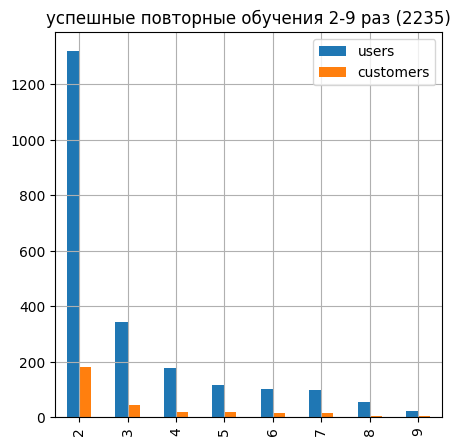

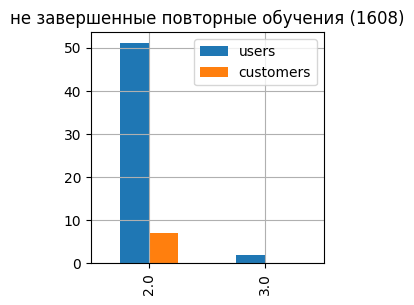

In [25]:
# ГИПОТЕЗА 2

# Примем, что `успешное обучение` это завершенное обучение.
# 1. Рассмотрим групы пользователей, которые проходили обучение повторно успешно или нет.
#    (1) пользователи обучавшиеся успешно:
tut_success = (counts_df[(counts_df.tutorial_finish >0)]).user_id.nunique()   #  10250
group_1fin = (counts_df[counts_df.tutorial_finish == 1]).user_id.nunique()    #  8015 - 1 раз
group_2fin = (counts_df[(counts_df.tutorial_finish >1)]).user_id.nunique()    #  2235 - 2-9 раз 

#    (2) пользователи начавшие обучение (на их счету в целом есть и успешные и неуспешные обучения):
tut_no_success = (counts_df[(counts_df.tutorial_start >0)]).user_id.nunique() #  11858
group_1start = (counts_df[counts_df.tutorial_start ==1]).user_id.nunique()    #  9103 - 1 раз
group_2start = (counts_df[(counts_df.tutorial_start >1)]).user_id.nunique()   #  2755 - 2-9 раз

#    (3) 1608 пользователей начинали, но не завершивили обучение ни разу (успешных обучений здесь нет):
counts_df['no_finished_studies'] = counts_df.apply(lambda x : x[1] if ((x[1]>0) & (x[2]==0)) else None, axis=1) 
no_finished_studies = counts_df.no_finished_studies.count()                                     #  1608
no_finished_1 = counts_df[(counts_df.tutorial_start ==1)&(counts_df.tutorial_finish ==0)]['user_id'].count()  #  1555 - 1 раз
no_finished_2 = counts_df[(counts_df.tutorial_start >1)&(counts_df.tutorial_finish ==0)]['user_id'].count()   #  53 - 2-3 раза


# 2. Подсчет количества обучений/ пользователей/ покупателей
#    (1) успешные обучения: колич.обучений(1-9) / пользователи(10250) / покупатели(1447)
count_users1 = counts_df[(counts_df.tutorial_finish >0)].tutorial_finish.value_counts()
count_customers1 = counts_df[(counts_df.tutorial_finish >0)&(counts_df.purchase ==1)].tutorial_finish.value_counts()

#    (2) начатые обучения: колич.обучений(1-9) / пользователи(11858) / покупатели(1578)
count_users2 = counts_df[(counts_df.tutorial_start >0)].tutorial_start.value_counts()
count_customers2 = counts_df[(counts_df.tutorial_start >0)&(counts_df.purchase ==1)].tutorial_start.value_counts()

#    (3) не успешные обучения: колич. обучений(1-3) / пользователи(1608) / покупатели(131)
count_users3 = counts_df.no_finished_studies.value_counts()
count_customers3 = counts_df[(counts_df.no_finished_studies >0)&(counts_df.purchase ==1)].no_finished_studies.value_counts()


# 3. Проверка доли оплат этих групп. Конкатанация series всех начал обучений / расчет вероятности оплаты
#    (1) успешные повторные обучения
df1 = pd.concat([count_users1, count_customers1], axis= 1) 
df1.columns = ['users', 'customers']            
df1 = df1.drop(1, axis=0) 
df1['CR'] = round(df1.customers/df1.users*100)   

#    (2) начатые обучения
df2 = pd.concat([count_users2, count_customers2], axis= 1) 
df2.columns = ['users', 'customers']
df2 = df2.drop(1, axis=0) 
df2['CR'] = round(df2.customers/df2.users*100) 

#    (3) не успешные обучения
df3 = pd.concat([count_users3, count_customers3], axis= 1) 
df3.columns = ['users','customers']  
df3 = df3.drop(1, axis=0) 
df3['CR'] = round(df3.customers/df3.users*100)



# 4. Визуализация
#    df1: успешные повторные обучения
display('успешные повторные обучения 2-9 раз ',df1)
df1.plot(
    y = ['users','customers'],
    kind='bar',
    grid=True,
    figsize=(5,5),
    legend=True,
    title='успешные повторные обучения 2-9 раз (2235)'
    );

#    df3: не успешные обучения
display('не завершенные повторные обучения (1608)',df3)
df3.plot(
    y = ['users','customers'],
    kind='bar',
    grid=True,
    figsize=(3,3),
    legend=True,
    title='не завершенные повторные обучения (1608)'
    );

# Выручка из total_df
# amount = total_df.pivot_table(index = 'user_id',values = 'amount', aggfunc = 'sum') 
# Добавление выручки в counts_df
# counts_df_amount = counts_df.merge(amount, on='user_id', how='inner')    
# sum_customers1 = counts_df_amount.groupby('finish_studies')['amount'].sum().reset_index()
# sum_customers2 = counts_df_amount.groupby('start_studies')['amount'].sum().reset_index()

### Резюмируем по Гипотезе № 2
### Повторное прохождение обучения положительно влияет на оплату
Проверим, существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь.

Всего в приложении зарегестрировались 19926 уникальных пользователей, из них:
- 10250 пользователей прошли успешное обучение - из них 1447 стали покупателями (87% всех продаж)

      8015 пользователей, прошли успешно обучение 1 раз > 1143 покупателя (CR = 14%)
      2235 пользователей, прошли обучение более 1 раза  >  304 покупателя (CR = 14%)
      
- 11858 пользователей начинали обучение - из них 1578 стали покупателями (99% всех продаж)

      9103 пользователей, начинали обучение 1 раз - 1207 покупателя (CR = 13%)
      2755 пользователей, начинали обучение более 1 раза -  371 покупателя (CR = 14%)
      
- 1608 пользователей начинали, но не завершивили обучение ни разу (успешных обучений здесь нет) - 131 покупатель (CR = 8%)

#### Повторное прохождение обучения положительно влияет на оплату в том случае, если оно успешно завершилось. С увеличением числа успешных обучений вероятность оплаты относительно числе пользователей в среднем сохраняется.
#### Пользователь, прошедщий обучение более 1 раза раза  с вероятностью 1 к 7  станет покупателем. 
#### Большинство (97%) пользователей, НЕ завершивших обучение уже ко второй попытке теряют интерес к обучению и  покупке в целом.
#### Количество пользователей, раз за разом возвращающихся к обучению уменьшается, но в среднем  вероятность покупки колеблется в районе 14%, что аналогично конверсии для пользователей с одним успешным обучением.
#### Вопрос - что заставляо пользователей обращаться к приложению повторно.


─────────────────────────────────────────────────────────────────────────────────────────────────────────────────
## ``ГИПОТЕЗА 3: Если пользователь сначала выбирает сложность обучения, будет ли он потом проходить обучение?``
Выяснить, как часто пользователи начинают обучение после выбора уровня сложности. Это позволит оценить прозрачность процесса взаимодействия с игрой: если пользователи после выбора уровня сложности обращаются к обучению, значит, работа с приложением непонятна.

    1. Рассмотрим группу пользователей, которые после регестрации сразу выбирают уровень сложности обучения
    2. Рассмотрим группу пользователей, которые выбирают сложность в середине своего пользовательского пути 
─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [26]:
# ГИПОТЕЗА 3

#  1. Рассмотрим группу пользователей, которые после регестрации сразу выбирают уровень сложности обучения - selected_level
#     8342 пользователя выбирали сложность когда либо в течении всего пользовательского пути
group_x = (counts_df[counts_df.level_choice > 0]).user_id.nunique()

#     Соберем датафрейм user_path из списков всех событий каждого пользователя по их очередности (19926 rows)
user_path = (total_df.groupby(['user_id'])['event_type'].apply(list).reset_index())  

#     98 пользователей следующим шагом после регестрациивыбирают level_choice, и никто из них далее НЕ начинает обучение    
user_path['events_x'] = user_path['event_type'].apply(lambda x: x if ('level_choice' in x) & ('tutorial_start' not in x) else None)
print('Группа из 98 пользователей, вбравших уровень сразу после реестрации')  
display(user_path.events_x.value_counts())


#     Есть ли  после выбора сложности начало обучения у пользователя (на протяжении всего пользовательского пути)?
#     Маркировка:  starts after level / NO starts after level 
def position(row):                               
    level = 'level_choice' 
    tutorial = 'tutorial_start'
    if (level in row) & (tutorial in row):
        start = row.index(level) # index  обытия level_choice
        end = len(row)-1         # длина списка - 1 элемент
        row_tail = row[start:end]
        if  tutorial in row_tail :
            y = row.index(tutorial, start, end) # index  обытия tutorial_start
            return 'starts after level'
        elif  tutorial not in row_tail:
            return 'NO starts after level'
    else: 
        return '-'  

#  2. Рассмотрим группу пользователей, которые выбирают сложность в середине своего пользовательского пути
#     8244 пользователя выбирают сложность в середине своего пользовательского пути, те не сразу после регестрации, из них:
#     6992 пользователи НЕ начинали обучение после выбора сложности
#     1252 - начинали обучение после выбора сложности
user_path['events_mark'] = user_path.event_type.apply(position)
print('Группа из 8244 пользователей, выбравших уровень НЕ сразу после реестрации')  
display(user_path.events_mark.value_counts())


  
# print('Все вторые по счету события после регестрации у пользователей')      
user_path['events_x1'] = user_path['event_type'].apply(lambda x: x[1] if ('level_choice' in x) else None) 
x1 = user_path.events_x1.value_counts()

# print('Группа из 8244 пользователей) 
user_path['events_x2'] = user_path['event_type'].apply(lambda x: x if ('level_choice' in x)&('tutorial_start' in x) else None)  
x2 = user_path.events_x2.value_counts().sort_values(ascending=False).head(10)



# display(user_path)
# Расчет долей
x1 = round(98/8342*100,1)   # 1.2%
x2 = round(1252/8342*100)   # 15%
x3 = round(6992/8342*100,1) # 83.8%

top1 = round(2796/8244*100) # 34% выбирают пакеты
top2 = round(1713/8244*100) # 21% завершают пользование
top3 = round(1083/8244*100) # 13% совершают покупку

Группа из 98 пользователей, вбравших уровень сразу после реестрации


[registration, level_choice, pack_choice]              52
[registration, level_choice]                           24
[registration, level_choice, pack_choice, purchase]    22
Name: events_x, dtype: int64

Группа из 8244 пользователей, выбравших уровень НЕ сразу после реестрации


-                        11682
NO starts after level     6992
starts after level        1252
Name: events_mark, dtype: int64

## Резюмируем по Гипотезе № 3
### Если пользователь сначала выбирает сложность обучения, будет ли он потом проходить обучение?
8342 пользотапелей выбирали сложность когда либо в течении всего пользовательского пути (``level_choice > 0``),  из них:
 
``98 пользователей``(1.2%) сразу выбирают уровень сложности, те level_choice - второе событие после регестрации. Из них абсолютно никто далее не возвращался к обучению.

``8244 пользователя`` сразу начинают обучение, те tutorial_start - второе событие после регестрации :
        
           1252 пользователя (15% из 8342) в процессе взаимодействия с приложением проходят этап, когда после выбора сложности они возвращаются к обучению.
           6992 пользователя (83.8% из 8342), те большинство не возвращаются к обучению после выбора сложности. Их самые популярные пути:
              2796 пользователя : регестрация > начало обучения > завершение обучения > выбор сложности > выбор пакетов
              1713 пользователя : регестрация > начало обучения > завершение обучения > выбор сложности 
              1083 пользователя : регестрация > начало обучения > завершение обучения > выбор сложности > выбор пакетов > покупка

#### В большинстве случаев пользователь после выбора сложности не возвращается к обучению. Можно предварительно сделать вывод о том, что данной группе (6992 пользователя) работа с приложением понятна, но вероятно что обучение руководству как таковое либо не интересно, либо не нужно. 
####  Так как далее больше половины пользователей, выбравших сложность, выбирают  пакеты (34%),  совершают покупку (13%) или завершают пользование (21%)
─────────────────────────────────────────────────────────────────────────────────────────────────────────────────
